<a href="https://colab.research.google.com/github/javmencia/COBWEBfiles/blob/main/PCPatientModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CLINICAL EARLY WARNING SYSTEM FOR MORTALITY PREDICTION

1. Loading data...
   Loaded 8121 samples with 106 features
DATA DIAGNOSIS
✓ VISDAY: Found (8056 non-NA values)
✓ os_event: Found (8121 non-NA values)
✓ DSDAY: Found (1265 non-NA values)
✓ RPT: Found (8121 non-NA values)

Total records: 8121
Unique patients (RPT): 526

os_event distribution:
  os_event = 0: 7023 records
  os_event = 1: 1098 records
  Missing os_event: 0 records

Patients who die (os_event=1):
  Count: 76

Sample patient 4 (who dies):
    VISDAY  DSDAY  os_event
76     0.0  309.0         1
78     8.0  309.0         1
69    16.0  309.0         1
70    29.0  309.0         1
71    38.0  309.0         1
72    58.0  309.0         1
77    79.0  309.0         1
73   155.0  309.0         1
74   239.0  309.0         1
75   309.0  309.0         1
  Unique DSDAY values: 1 (non-NA: 1)
  Death day: 309.0

VISDAY vs DSDAY analysis:
  Visits after death (VISDAY > DSDAY): 10
  Visits on death day (VISDAY == DSDAY): 77
  Visits bef

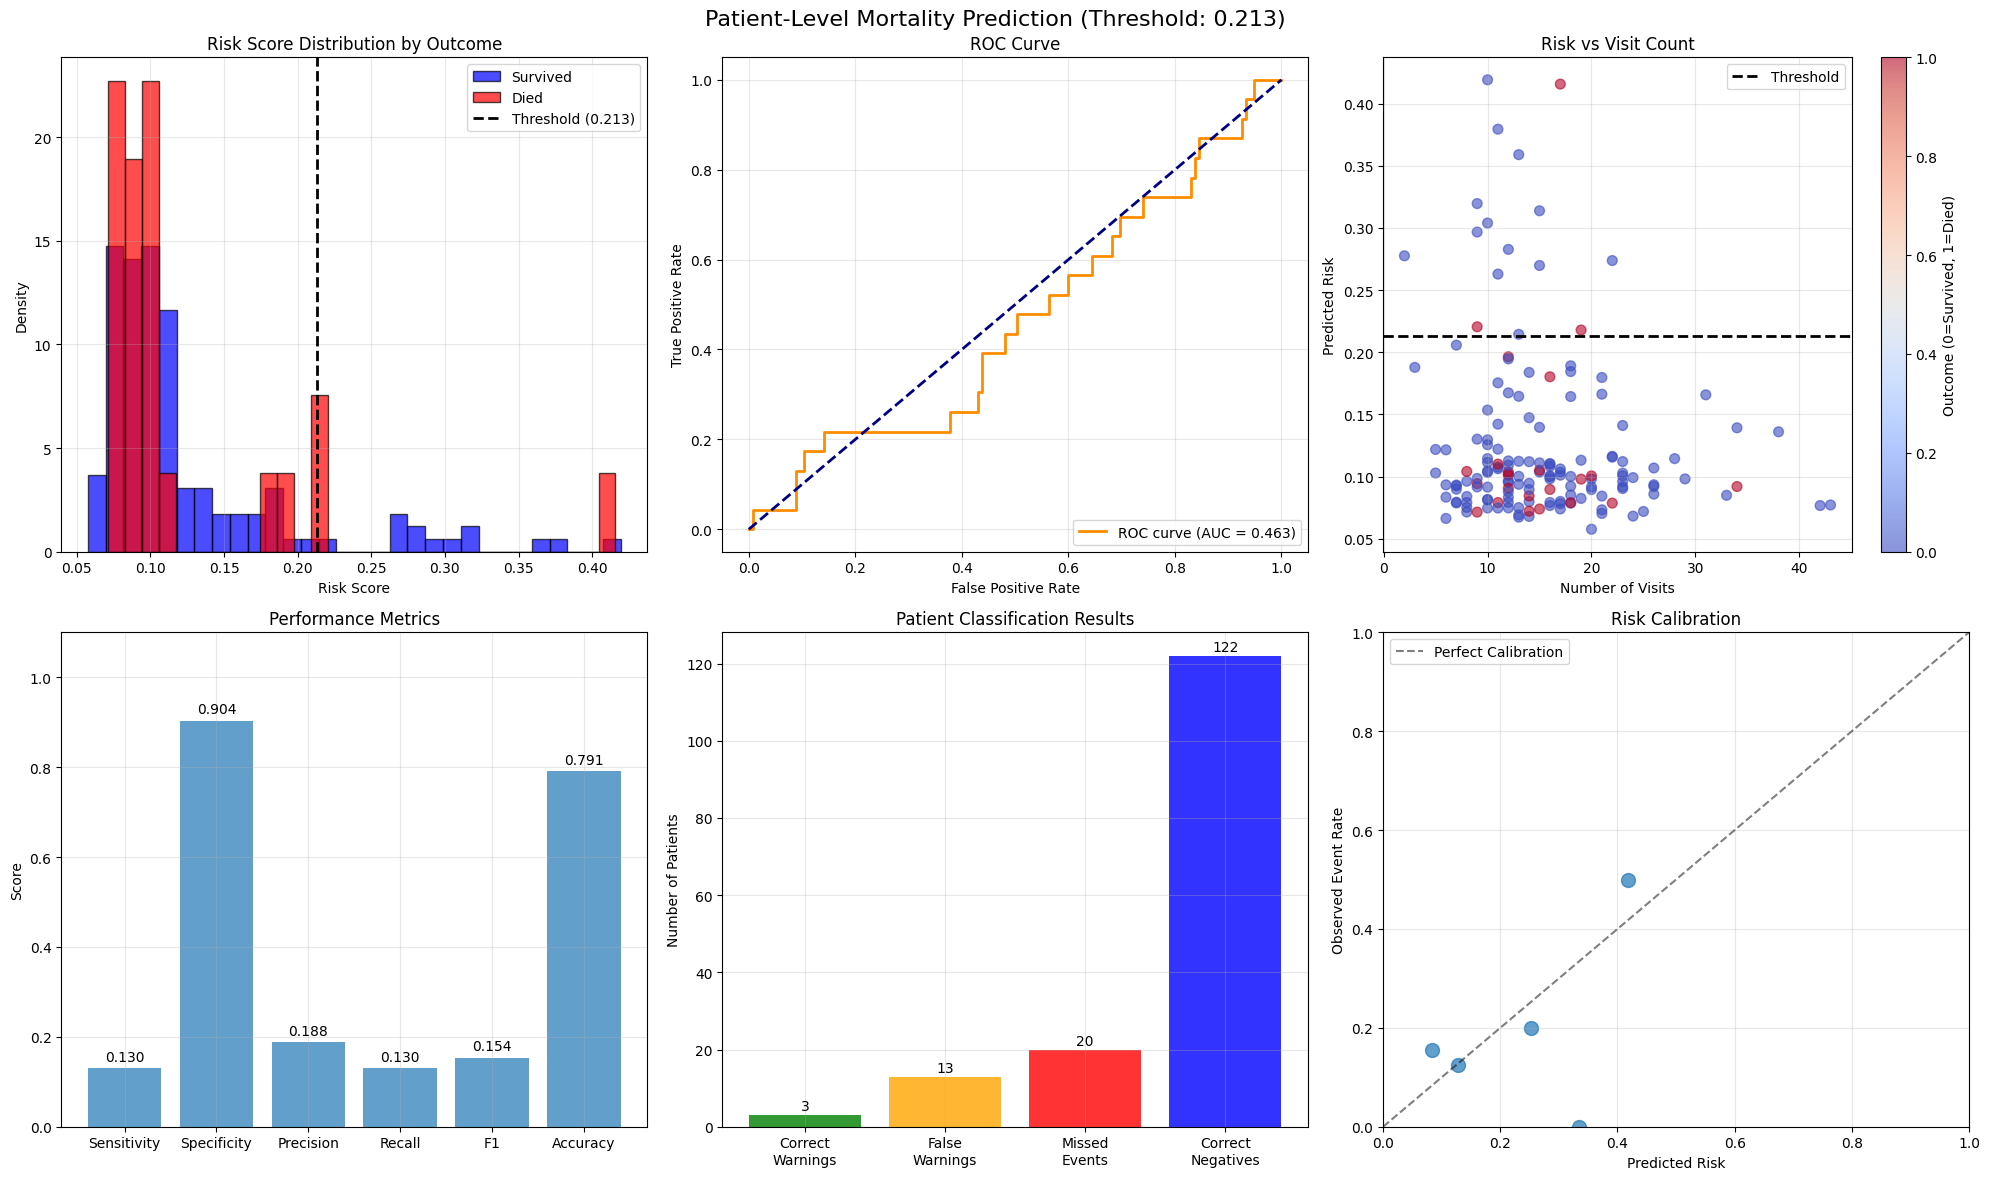


9. Making final predictions on all patients...
Using autoencoder imputation: True
Using 31 available features
Categorical columns: 0
Numeric columns: 31
Train data shape before imputation: (1470, 31)
Test data shape before imputation: (2630, 31)
Missing values in train: 868 (1.9%)
Missing values in test: 1547 (1.9%)

Fitting autoencoder on training data...
Autoencoder trained on 681 complete cases
Imputing missing values in training set...
Autoencoder imputation converged after 5 iterations
Imputing missing values in test set...
Autoencoder imputation converged after 5 iterations
Missing values after autoencoder imputation (train): 0
Missing values after autoencoder imputation (test): 0
Error: cannot reshape array of size 1160330 into shape (526,5,31)


Traceback (most recent call last):
  File "/tmp/ipython-input-927608745.py", line 1858, in run_clinical_early_warning
    results = warning_pipeline.run_patient_level_pipeline(pcdata)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-927608745.py", line 1509, in run_patient_level_pipeline
    all_imputed = all_imputed_flat.reshape(n_all_samples, seq_len, n_features)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: cannot reshape array of size 1160330 into shape (526,5,31)


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

class AutoencoderImputer:
    def __init__(self, encoding_dim=32, epochs=50, batch_size=32, random_state=42):
        self.encoding_dim = encoding_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.autoencoder = None
        self.is_fitted = False

    def build_autoencoder(self, input_dim):
        """Build a deep autoencoder for imputation"""
        input_layer = layers.Input(shape=(input_dim,))

        # Encoder
        encoded = layers.Dense(128, activation='relu')(input_layer)
        encoded = layers.Dropout(0.2)(encoded)
        encoded = layers.Dense(64, activation='relu')(encoded)
        encoded = layers.Dropout(0.2)(encoded)
        encoded = layers.Dense(self.encoding_dim, activation='relu')(encoded)

        # Decoder
        decoded = layers.Dense(64, activation='relu')(encoded)
        decoded = layers.Dropout(0.2)(decoded)
        decoded = layers.Dense(128, activation='relu')(decoded)
        decoded = layers.Dropout(0.2)(decoded)
        decoded = layers.Dense(input_dim, activation='linear')(decoded)

        # Autoencoder model
        autoencoder = models.Model(input_layer, decoded)

        # Encoder model (for feature extraction)
        encoder = models.Model(input_layer, encoded)

        autoencoder.compile(optimizer=Adam(learning_rate=0.001),
                           loss='mse',
                           metrics=['mae'])

        return autoencoder, encoder

    def fit_imputer(self, X_train):
        """Train autoencoder on complete data"""
        # Create mask for complete cases
        complete_mask = ~np.any(np.isnan(X_train), axis=1)
        X_complete = X_train[complete_mask]

        if len(X_complete) < 10:
            print(f"Warning: Only {len(X_complete)} complete cases for autoencoder training")
            return self

        # Scale the data
        X_scaled = self.scaler.fit_transform(X_complete)

        # Build and train autoencoder
        self.autoencoder, self.encoder = self.build_autoencoder(X_scaled.shape[1])

        early_stop = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            min_delta=0.001
        )

        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )

        # Train-validation split
        X_train_split, X_val_split = train_test_split(
            X_scaled, test_size=0.2, random_state=self.random_state
        )

        self.autoencoder.fit(
            X_train_split, X_train_split,
            epochs=self.epochs,
            batch_size=self.batch_size,
            validation_data=(X_val_split, X_val_split),
            callbacks=[early_stop, reduce_lr],
            verbose=0
        )

        self.is_fitted = True
        print(f"Autoencoder trained on {len(X_complete)} complete cases")

        return self

    def impute_missing_values(self, X, max_iter=20, tol=1e-4):
        """Impute missing values using trained autoencoder with iterative refinement"""
        if not self.is_fitted:
            print("Autoencoder not fitted. Fitting now...")
            self.fit_imputer(X)
            if not self.is_fitted:
                return X  # Return original if still not fitted

        X_imputed = X.copy()

        # Check for missing values
        if not np.any(np.isnan(X_imputed)):
            return X_imputed

        # Initial imputation with median
        for i in range(X_imputed.shape[1]):
            col_data = X_imputed[:, i]
            if np.any(np.isnan(col_data)):
                median_val = np.nanmedian(col_data)
                if np.isnan(median_val):
                    median_val = 0
                col_data[np.isnan(col_data)] = median_val
                X_imputed[:, i] = col_data

        # Iterative refinement
        for iteration in range(max_iter):
            X_old = X_imputed.copy()

            # Scale
            X_scaled = self.scaler.transform(X_imputed)

            # Get reconstructions
            X_reconstructed = self.autoencoder.predict(X_scaled, verbose=0)
            X_reconstructed = self.scaler.inverse_transform(X_reconstructed)

            # Only update missing values
            missing_mask = np.isnan(X)
            X_imputed[missing_mask] = X_reconstructed[missing_mask]

            # Check convergence
            if iteration > 0:
                change = np.linalg.norm(X_imputed - X_old) / np.linalg.norm(X_old)
                if change < tol:
                    print(f"Autoencoder imputation converged after {iteration+1} iterations")
                    break

        return X_imputed

class RobustTimeAwareDataProcessor:
    def __init__(self, use_autoencoder=True):
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.use_autoencoder = use_autoencoder
        self.autoencoder_imputer = AutoencoderImputer() if use_autoencoder else None
        self.feature_names = None

    def clean_data(self, df):
        """Clean data by handling infinity, large values, and missing data"""
        df_clean = df.copy()

        # Replace infinity with NaN
        df_clean = df_clean.replace([np.inf, -np.inf], np.nan)

        # Handle extremely large values by capping at 99th percentile
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if df_clean[col].notna().any():
                # Cap at 99th percentile
                p99 = df_clean[col].quantile(0.99)
                if not np.isnan(p99):
                    df_clean[col] = df_clean[col].clip(upper=p99 * 10)  # Allow some margin

        return df_clean

    def process_patient_data(self, df):
        """Process data with proper temporal structure using DSDAY for death timing"""
        # Clean data first
        df_clean = self.clean_data(df)

        # Handle missing survival data
        missing_before = len(df_clean)
        df_clean = df_clean.dropna(subset=['VISDAY'])
        missing_after = len(df_clean)
        print(f"Removed {missing_before - missing_after} rows with missing VISDAY")

        # Check for required columns
        if 'DSDAY' not in df_clean.columns:
            print("ERROR: DSDAY column not found. This is required for death timing.")
            print("Available columns:", df_clean.columns.tolist())
            return None

        # Create patient IDs
        if 'RPT' in df_clean.columns:
            df_clean['patient_id'] = df_clean['RPT']
            print(f"Using 'RPT' as patient identifier")
        elif 'patient_id' not in df_clean.columns:
            possible_id_cols = ['SUBJID', 'PATIENT', 'patient', 'id', 'ID']
            for col in possible_id_cols:
                if col in df_clean.columns:
                    df_clean['patient_id'] = df_clean[col]
                    print(f"Using '{col}' as patient identifier")
                    break

        # Sort by patient and visit day
        df_sorted = df_clean.sort_values(['patient_id', 'VISDAY']).reset_index(drop=True)

        # DEBUG: Check data structure
        print(f"\nDEBUG: Checking first few rows...")
        print(df_sorted[['patient_id', 'VISDAY', 'DSDAY', 'os_event']].head(10))

        # Calculate time to event for each visit
        print("\nCalculating time-to-event for each visit...")
        df_sorted['time_to_event'] = np.nan
        df_sorted['is_future_event'] = 0

        unique_patients = df_sorted['patient_id'].unique()
        print(f"Processing {len(unique_patients)} patients...")

        for i, pid in enumerate(unique_patients):
            if i % 200 == 0:
                print(f"  Processed {i}/{len(unique_patients)} patients...")

            patient_data = df_sorted[df_sorted['patient_id'] == pid].copy()

            # DEBUG for first few patients
            if i < 10:
                print(f"\nDEBUG Patient {pid}:")
                print(f"  Total visits: {len(patient_data)}")
                print(f"  os_event values: {patient_data['os_event'].unique()}")
                print(f"  VISDAY range: {patient_data['VISDAY'].min()} to {patient_data['VISDAY'].max()}")
                print(f"  DSDAY values: {patient_data['DSDAY'].unique()}")
                print(f"  Non-NA DSDAY count: {patient_data['DSDAY'].notna().sum()}")

            # Check if patient died (has os_event = 1 AND has DSDAY)
            patient_events = patient_data['os_event'].values
            patient_dsdays = patient_data['DSDAY'].values

            # Find non-NaN DSDAY values for this patient
            valid_dsday_mask = ~pd.isna(patient_dsdays)

            if np.any(patient_events == 1) and np.any(valid_dsday_mask):
                # Patient died - get death day from DSDAY
                # DSDAY should be consistent across all rows for a patient
                death_day = patient_data.loc[valid_dsday_mask, 'DSDAY'].iloc[0]

                print(f"  Patient {pid}: Death on day {death_day}")

                # For each visit, check if it occurs before death
                future_event_count = 0
                for idx, row in patient_data.iterrows():
                    if row['VISDAY'] < death_day:
                        # Visit occurs BEFORE death
                        days_to_death = death_day - row['VISDAY']
                        df_sorted.at[idx, 'time_to_event'] = days_to_death
                        df_sorted.at[idx, 'is_future_event'] = 1
                        future_event_count += 1
                    elif row['VISDAY'] == death_day:
                        # Visit occurs ON death day
                        df_sorted.at[idx, 'time_to_event'] = 0
                        df_sorted.at[idx, 'is_future_event'] = 0
                    elif row['VISDAY'] > death_day:
                        # Visit occurs AFTER death (shouldn't happen with proper data)
                        df_sorted.at[idx, 'time_to_event'] = -1  # Negative means after death
                        df_sorted.at[idx, 'is_future_event'] = 0
                    else:
                        # Shouldn't reach here
                        df_sorted.at[idx, 'time_to_event'] = np.nan
                        df_sorted.at[idx, 'is_future_event'] = 0

                print(f"  Patient {pid}: {future_event_count} visits occur BEFORE death")

                # DEBUG: Show some time-to-event calculations
                if i < 5 and future_event_count > 0:
                    future_visits = patient_data[patient_data['VISDAY'] < death_day]
                    print(f"    First few future event calculations:")
                    for _, visit in future_visits.head(3).iterrows():
                        print(f"      VISDAY={visit['VISDAY']}, DSDAY={death_day}, Days to death={death_day - visit['VISDAY']}")

            else:
                # Patient survived (os_event = 0 or missing DSDAY)
                last_visit_day = patient_data['VISDAY'].max()

                for idx, row in patient_data.iterrows():
                    days_from_last = last_visit_day - row['VISDAY']
                    df_sorted.at[idx, 'time_to_event'] = days_from_last
                    df_sorted.at[idx, 'is_future_event'] = 0

                if np.any(patient_events == 1) and not np.any(valid_dsday_mask):
                    print(f"  Patient {pid}: WARNING - os_event=1 but no DSDAY! Assuming censored.")

        # Summary statistics
        print(f"\nPROCESSING COMPLETE:")
        print(f"Total patients: {len(unique_patients)}")

        # Count patients with death events
        death_patients = df_sorted[df_sorted['os_event'] == 1]['patient_id'].unique()
        print(f"Patients with os_event=1: {len(death_patients)}")

        # Count patients with valid DSDAY
        patients_with_dsday = df_sorted[df_sorted['DSDAY'].notna()]['patient_id'].unique()
        print(f"Patients with DSDAY: {len(patients_with_dsday)}")

        # Count future events
        total_future_events = df_sorted['is_future_event'].sum()
        print(f"Visits that occur BEFORE death (future events): {total_future_events}")
        print(f"Percentage of visits with future events: {total_future_events/len(df_sorted)*100:.1f}%")

        # Show distribution of time_to_event for future events
        future_events_data = df_sorted[df_sorted['is_future_event'] == 1]
        if len(future_events_data) > 0:
            print(f"\nTime-to-event distribution for future events:")
            print(f"  Mean: {future_events_data['time_to_event'].mean():.1f} days")
            print(f"  Median: {future_events_data['time_to_event'].median():.1f} days")
            print(f"  Min: {future_events_data['time_to_event'].min():.1f} days")
            print(f"  Max: {future_events_data['time_to_event'].max():.1f} days")

            # Show patients with the most future events
            patient_future_counts = df_sorted.groupby('patient_id')['is_future_event'].sum()
            top_patients = patient_future_counts.nlargest(5)
            print(f"\nPatients with most future events:")
            for pid, count in top_patients.items():
                patient_data = df_sorted[df_sorted['patient_id'] == pid]
                death_day = patient_data['DSDAY'].iloc[0] if patient_data['DSDAY'].notna().any() else 'N/A'
                print(f"  Patient {pid}: {count} future events, Death day: {death_day}")

        # Debug: Check a specific patient
        print(f"\nDEBUG: Checking patient who dies (first one)...")
        if len(death_patients) > 0:
            sample_pid = death_patients[0]
            sample_data = df_sorted[df_sorted['patient_id'] == sample_pid]
            print(f"Patient {sample_pid}:")
            print(sample_data[['VISDAY', 'DSDAY', 'os_event', 'time_to_event', 'is_future_event']].to_string())

        return df_sorted

    def prepare_features_with_autoencoder(self, df_train, df_test, feature_names):
        """Prepare features with autoencoder imputation for train and test separately"""
        print(f"Using autoencoder imputation: {self.use_autoencoder}")

        # Select features that exist in dataframe
        available_features = [f for f in feature_names if f in df_train.columns]
        print(f"Using {len(available_features)} available features")

        # Prepare train and test data
        X_train_raw = df_train[available_features].copy()
        X_test_raw = df_test[available_features].copy()

        # Replace any infinity values
        X_train_raw = X_train_raw.replace([np.inf, -np.inf], np.nan)
        X_test_raw = X_test_raw.replace([np.inf, -np.inf], np.nan)

        # Handle categorical variables
        categorical_cols = X_train_raw.select_dtypes(exclude=[np.number]).columns
        numeric_cols = X_train_raw.select_dtypes(include=[np.number]).columns

        print(f"Categorical columns: {len(categorical_cols)}")
        print(f"Numeric columns: {len(numeric_cols)}")

        # Encode categorical variables
        encoded_train = []
        encoded_test = []

        for col in categorical_cols:
            try:
                if col not in self.label_encoders:
                    self.label_encoders[col] = LabelEncoder()
                    # Combine train and test for fitting to handle all categories
                    combined = pd.concat([X_train_raw[col], X_test_raw[col]], ignore_index=True)
                    combined = combined.astype(str).fillna('missing')
                    self.label_encoders[col].fit(combined)

                # Transform train and test
                train_encoded = self.label_encoders[col].transform(
                    X_train_raw[col].astype(str).fillna('missing')
                )
                test_encoded = self.label_encoders[col].transform(
                    X_test_raw[col].astype(str).fillna('missing')
                )

                encoded_train.append(train_encoded.reshape(-1, 1))
                encoded_test.append(test_encoded.reshape(-1, 1))

            except Exception as e:
                print(f"Warning: Could not encode column {col}: {e}")
                # Drop problematic column
                continue

        # Combine categorical and numeric data
        X_train_combined = []
        X_test_combined = []

        if len(categorical_cols) > 0 and encoded_train:
            X_train_cat = np.hstack(encoded_train)
            X_test_cat = np.hstack(encoded_test)
            X_train_combined.append(X_train_cat)
            X_test_combined.append(X_test_cat)

        if len(numeric_cols) > 0:
            X_train_num = X_train_raw[numeric_cols].values
            X_test_num = X_test_raw[numeric_cols].values
            X_train_combined.append(X_train_num)
            X_test_combined.append(X_test_num)

        # Combine all features
        if X_train_combined:
            X_train = np.hstack(X_train_combined)
            X_test = np.hstack(X_test_combined)
        else:
            print("Warning: No features available after preprocessing")
            return None, None, available_features

        print(f"Train data shape before imputation: {X_train.shape}")
        print(f"Test data shape before imputation: {X_test.shape}")
        print(f"Missing values in train: {np.isnan(X_train).sum()} ({np.isnan(X_train).mean()*100:.1f}%)")
        print(f"Missing values in test: {np.isnan(X_test).sum()} ({np.isnan(X_test).mean()*100:.1f}%)")

        if self.use_autoencoder and self.autoencoder_imputer:
            # Fit autoencoder on training data
            print("\nFitting autoencoder on training data...")
            self.autoencoder_imputer.fit_imputer(X_train)

            # Impute missing values separately for train and test
            print("Imputing missing values in training set...")
            X_train_imputed = self.autoencoder_imputer.impute_missing_values(X_train)

            print("Imputing missing values in test set...")
            X_test_imputed = self.autoencoder_imputer.impute_missing_values(X_test)

            # Scale the imputed data
            X_train_scaled = self.scaler.fit_transform(X_train_imputed)
            X_test_scaled = self.scaler.transform(X_test_imputed)

            print(f"Missing values after autoencoder imputation (train): {np.isnan(X_train_scaled).sum()}")
            print(f"Missing values after autoencoder imputation (test): {np.isnan(X_test_scaled).sum()}")

            return X_train_scaled, X_test_scaled, available_features
        else:
            # Fallback: Simple imputation
            print("Using simple imputation (median/mode)...")

            # Impute missing values with median for numeric, mode for categorical
            for i in range(X_train.shape[1]):
                # Train imputation
                train_col = X_train[:, i]
                if np.any(np.isnan(train_col)):
                    if i < len(categorical_cols):
                        # Categorical - use mode
                        mode_val = np.nanmode(train_col)
                        if np.isnan(mode_val):
                            mode_val = 0
                        X_train[:, i] = np.nan_to_num(train_col, nan=mode_val)
                    else:
                        # Numeric - use median
                        median_val = np.nanmedian(train_col)
                        if np.isnan(median_val):
                            median_val = 0
                        X_train[:, i] = np.nan_to_num(train_col, nan=median_val)

                # Test imputation (using statistics from train)
                test_col = X_test[:, i]
                if np.any(np.isnan(test_col)):
                    if i < len(categorical_cols):
                        # Categorical - use mode from train
                        mode_val = np.nanmode(X_train[:, i])
                        if np.isnan(mode_val):
                            mode_val = 0
                        X_test[:, i] = np.nan_to_num(test_col, nan=mode_val)
                    else:
                        # Numeric - use median from train
                        median_val = np.nanmedian(X_train[:, i])
                        if np.isnan(median_val):
                            median_val = 0
                        X_test[:, i] = np.nan_to_num(test_col, nan=median_val)

            # Scale the data
            X_train_scaled = self.scaler.fit_transform(X_train)
            X_test_scaled = self.scaler.transform(X_test)

            return X_train_scaled, X_test_scaled, available_features

    def prepare_features(self, df, feature_names):
        """Legacy method for backward compatibility - prepares features without train/test split"""
        print("Warning: Using legacy prepare_features method without train/test split")

        # Select features that exist in dataframe
        available_features = [f for f in feature_names if f in df.columns]
        print(f"Using {len(available_features)} available features")

        # Handle missing values
        df_filled = df[available_features].copy()

        # Replace any remaining infinity values
        df_filled = df_filled.replace([np.inf, -np.inf], np.nan)

        # Fill numeric missing values with median
        numeric_cols = df_filled.select_dtypes(include=[np.number]).columns
        print(f"Processing {len(numeric_cols)} numeric columns...")

        for col in numeric_cols:
            if df_filled[col].isnull().any():
                median_val = df_filled[col].median()
                if pd.isna(median_val):
                    median_val = 0  # Fallback
                df_filled[col] = df_filled[col].fillna(median_val)

        # Fill categorical missing values with mode
        categorical_cols = df_filled.select_dtypes(exclude=[np.number]).columns
        print(f"Processing {len(categorical_cols)} categorical columns...")

        for col in categorical_cols:
            if df_filled[col].isnull().any():
                mode_val = df_filled[col].mode()
                if len(mode_val) > 0:
                    df_filled[col] = df_filled[col].fillna(mode_val[0])
                else:
                    df_filled[col] = df_filled[col].fillna('missing')

        # Encode categorical variables
        print("Encoding categorical variables...")
        for col in categorical_cols:
            try:
                if col not in self.label_encoders:
                    self.label_encoders[col] = LabelEncoder()
                    # Handle any non-string values
                    col_data = df_filled[col].astype(str)
                    self.label_encoders[col].fit(col_data)

                df_filled[col] = self.label_encoders[col].transform(df_filled[col].astype(str))
            except Exception as e:
                print(f"Warning: Could not encode column {col}: {e}")
                # Drop problematic column
                df_filled = df_filled.drop(columns=[col])
                available_features.remove(col)

        # Scale numeric features
        if len(numeric_cols) > 0:
            print("Scaling numeric features...")
            # Check for any remaining issues
            numeric_data = df_filled[numeric_cols].values
            if np.any(np.isnan(numeric_data)) or np.any(np.isinf(numeric_data)):
                print("Warning: NaN or Inf found in numeric data after cleaning")
                # Replace with zeros as last resort
                numeric_data = np.nan_to_num(numeric_data, nan=0.0, posinf=1e6, neginf=-1e6)
                df_filled[numeric_cols] = numeric_data

            try:
                df_filled[numeric_cols] = self.scaler.fit_transform(df_filled[numeric_cols])
            except Exception as e:
                print(f"Warning: Could not scale features: {e}")
                # Use min-max scaling as fallback
                for col in numeric_cols:
                    col_min = df_filled[col].min()
                    col_max = df_filled[col].max()
                    if col_max > col_min:
                        df_filled[col] = (df_filled[col] - col_min) / (col_max - col_min)
                    else:
                        df_filled[col] = 0

        print(f"Final feature matrix shape: {df_filled.shape}")
        return df_filled.values, available_features

    def create_temporal_sequences(self, df, feature_cols, max_sequence_length=5, prediction_horizon=90):
        """Create sequences with proper temporal structure using DSDAY for death timing"""
        print("Creating temporal sequences...")
        sequences = []
        labels = []
        time_intervals = []
        patient_ids = []
        days_to_event_list = []

        unique_patients = df['patient_id'].unique()

        for pid in unique_patients:
            patient_data = df[df['patient_id'] == pid].sort_values('VISDAY')

            if len(patient_data) < 2:
                continue  # Need at least 2 visits

            # Get features and temporal data
            patient_features = patient_data[feature_cols].values
            patient_visdays = patient_data['VISDAY'].values
            patient_time_to_event = patient_data['time_to_event'].values
            patient_has_event = patient_data['is_future_event'].values

            # Create sequences
            for i in range(1, len(patient_data)):  # Start from 1 to have at least one previous visit
                # Determine sequence length (up to max_sequence_length)
                seq_len = min(i, max_sequence_length)
                start_idx = i - seq_len

                # Get sequence data
                seq_features = patient_features[start_idx:i+1]  # Including current visit
                seq_visdays = patient_visdays[start_idx:i+1]

                # Calculate time intervals between visits (in days)
                if len(seq_visdays) > 1:
                    time_diffs = np.diff(seq_visdays)
                    # Add a default 30-day interval for the first gap
                    time_diffs = np.concatenate([[30], time_diffs])
                else:
                    time_diffs = np.array([30])

                # Normalize time intervals (divide by 30 to get approximate months)
                time_diffs_normalized = time_diffs / 30.0

                # Create label: will death occur within prediction horizon?
                current_time_to_event = patient_time_to_event[i]
                current_has_event = patient_has_event[i]

                # Label is 1 if: this visit occurs before death AND death will happen within horizon
                if current_has_event == 1 and current_time_to_event <= prediction_horizon:
                    label = 1  # Death will occur within horizon
                else:
                    label = 0  # No death within horizon

                # Pad sequence if needed
                if seq_len < max_sequence_length:
                    pad_len = max_sequence_length - seq_len
                    seq_features = np.pad(seq_features, ((pad_len, 0), (0, 0)), mode='constant')
                    time_diffs_normalized = np.pad(time_diffs_normalized, (pad_len, 0),
                                                  mode='constant', constant_values=1.0)  # 1 month for padding

                sequences.append(seq_features)
                labels.append(label)
                time_intervals.append(time_diffs_normalized)
                patient_ids.append(pid)
                days_to_event_list.append(current_time_to_event)

        sequences = np.array(sequences)
        labels = np.array(labels)
        time_intervals = np.array(time_intervals)
        patient_ids = np.array(patient_ids)

        print(f"\nCreated {len(sequences)} sequences")
        print(f"Positive sequences (death within {prediction_horizon} days): {np.sum(labels == 1)} ({np.mean(labels == 1)*100:.1f}%)")
        print(f"Negative sequences: {np.sum(labels == 0)}")

        # Analyze positive sequences
        if np.sum(labels == 1) > 0:
            positive_days = np.array(days_to_event_list)[labels == 1]
            print(f"\nDays to event for positive sequences (alerts):")
            print(f"  Mean: {np.mean(positive_days):.1f} days")
            print(f"  Median: {np.median(positive_days):.1f} days")
            print(f"  Range: {np.min(positive_days):.1f} to {np.max(positive_days):.1f} days")

            # Show distribution
            print(f"  Distribution:")
            for threshold in [7, 14, 30, 60, 90]:
                count = np.sum(positive_days <= threshold)
                percentage = count / len(positive_days) * 100
                print(f"    ≤{threshold} days: {count} alerts ({percentage:.1f}%)")

        # Show some examples
        print(f"\nDEBUG: Sample alerts (first 5):")
        alert_count = 0
        for i in range(min(100, len(labels))):
            if labels[i] == 1 and alert_count < 5:
                pid = patient_ids[i]
                days = days_to_event_list[i]
                print(f"  Patient {pid}: Alert at {days:.0f} days before death")
                alert_count += 1

        return sequences, labels, time_intervals, patient_ids, days_to_event_list

    def create_patient_level_sequences(self, df, feature_cols, max_sequence_length=5, prediction_horizon=90):
        """Create ONE sequence per patient with proper temporal structure"""
        print("Creating patient-level temporal sequences...")
        sequences = []
        patient_labels = []  # Patient-level labels (1 = dies eventually, 0 = survives)
        time_intervals = []
        patient_ids = []
        patient_days_to_event = []  # Days to event at last visit
        patient_visit_counts = []

        unique_patients = df['patient_id'].unique()

        for pid in unique_patients:
            patient_data = df[df['patient_id'] == pid].sort_values('VISDAY')

            if len(patient_data) < 1:
                continue  # Need at least 1 visit

            # Get features and temporal data
            patient_features = patient_data[feature_cols].values
            patient_visdays = patient_data['VISDAY'].values
            patient_time_to_event = patient_data['time_to_event'].values
            patient_has_event = patient_data['is_future_event'].values
            patient_os_event = patient_data['os_event'].values

            # Determine patient-level label: patient eventually dies (1) or survives (0)
            patient_dies_eventually = 1 if np.any(patient_os_event == 1) else 0

            # Use ALL available visits for the patient (up to max_sequence_length)
            seq_len = min(len(patient_data), max_sequence_length)
            start_idx = max(0, len(patient_data) - seq_len)

            # Get sequence data (most recent visits)
            seq_features = patient_features[start_idx:start_idx + seq_len]
            seq_visdays = patient_visdays[start_idx:start_idx + seq_len]

            # Calculate time intervals between visits (in days)
            if len(seq_visdays) > 1:
                time_diffs = np.diff(seq_visdays)
                # Add a default 30-day interval for the first gap
                time_diffs = np.concatenate([[30], time_diffs])
            else:
                time_diffs = np.array([30])

            # Normalize time intervals
            time_diffs_normalized = time_diffs / 30.0

            # Pad sequence if needed
            if seq_len < max_sequence_length:
                pad_len = max_sequence_length - seq_len
                seq_features = np.pad(seq_features, ((pad_len, 0), (0, 0)), mode='constant')
                time_diffs_normalized = np.pad(time_diffs_normalized, (pad_len, 0),
                                              mode='constant', constant_values=1.0)

            sequences.append(seq_features)
            patient_labels.append(patient_dies_eventually)
            time_intervals.append(time_diffs_normalized)
            patient_ids.append(pid)
            patient_visit_counts.append(len(patient_data))

            # Get days to event at the LAST visit
            last_time_to_event = patient_time_to_event[-1]
            patient_days_to_event.append(last_time_to_event)

        sequences = np.array(sequences)
        patient_labels = np.array(patient_labels)
        time_intervals = np.array(time_intervals)
        patient_ids = np.array(patient_ids)
        patient_days_to_event = np.array(patient_days_to_event)  # Convert to numpy array
        patient_visit_counts = np.array(patient_visit_counts)    # Convert to numpy array

        print(f"\nCreated {len(sequences)} patient-level sequences")
        print(f"Patients who eventually die: {np.sum(patient_labels == 1)} ({np.mean(patient_labels == 1)*100:.1f}%)")
        print(f"Patients who survive: {np.sum(patient_labels == 0)} ({np.mean(patient_labels == 0)*100:.1f}%)")
        print(f"Average visits per patient: {np.mean(patient_visit_counts):.1f}")

        return sequences, patient_labels, time_intervals, patient_ids, patient_days_to_event, patient_visit_counts

class TimeAwareEarlyWarningModel:
    def __init__(self, input_dim, sequence_length=5, lstm_units=64):
        self.input_dim = input_dim
        self.sequence_length = sequence_length
        self.lstm_units = lstm_units
        self.model = None
        self.history = None

    def build_model_with_time_awareness(self):
        """Build model that incorporates time intervals between visits"""
        # Two input layers: features and time intervals
        feature_input = layers.Input(shape=(self.sequence_length, self.input_dim), name='features')
        time_input = layers.Input(shape=(self.sequence_length, 1), name='time_intervals')

        # Process time intervals
        time_processed = layers.Dense(8, activation='relu')(time_input)
        time_processed = layers.Dense(16, activation='relu')(time_processed)

        # Concatenate features with time information
        combined = layers.Concatenate(axis=-1)([feature_input, time_processed])

        # LSTM layers
        lstm_out = layers.Bidirectional(layers.LSTM(self.lstm_units, return_sequences=True))(combined)
        lstm_out = layers.Dropout(0.3)(lstm_out)

        # Simple attention mechanism
        attention_scores = layers.TimeDistributed(layers.Dense(1, activation='tanh'))(lstm_out)
        attention_weights = layers.Softmax(axis=1)(attention_scores)
        context_vector = layers.Multiply()([lstm_out, attention_weights])

        # Global average pooling instead of just last time step
        pooled = layers.GlobalAveragePooling1D()(context_vector)

        # Dense layers
        dense1 = layers.Dense(64, activation='relu')(pooled)
        dense1 = layers.BatchNormalization()(dense1)
        dense1 = layers.Dropout(0.3)(dense1)

        dense2 = layers.Dense(32, activation='relu')(dense1)
        dense2 = layers.BatchNormalization()(dense2)
        dense2 = layers.Dropout(0.2)(dense2)

        # Output: risk of event within prediction horizon
        risk_score = layers.Dense(1, activation='sigmoid', name='risk_score')(dense2)

        # Create model
        self.model = models.Model(inputs=[feature_input, time_input], outputs=risk_score)

        return self.model

    def compile_model(self, learning_rate=0.001):
        """Compile the model"""
        self.model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc'),
                    tf.keras.metrics.Precision(name='precision'),
                    tf.keras.metrics.Recall(name='recall')]
        )

        return self.model

    def train(self, X_features, X_time, y_train, val_data=None, epochs=100, batch_size=32, class_weight=None):
        """Train the model"""
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss' if val_data else 'loss',
            patience=15,
            restore_best_weights=True,
            min_delta=0.001,
            verbose=0
        )

        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss' if val_data else 'loss',
            factor=0.5,
            patience=8,
            min_lr=1e-6,
            verbose=0
        )

        callbacks_list = [early_stopping, reduce_lr]

        if val_data:
            X_val_features, X_val_time, y_val = val_data
            validation_data = ([X_val_features, X_val_time], y_val)
        else:
            validation_data = None

        self.history = self.model.fit(
            [X_features, X_time], y_train,
            validation_data=validation_data,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks_list,
            verbose=0,
            class_weight=class_weight
        )

        return self.history

    def predict(self, X_features, X_time):
        """Make predictions"""
        return self.model.predict([X_features, X_time], verbose=0).flatten()

class ClinicalEarlyWarningPipeline:
    def __init__(self, prediction_horizon_days=90, n_splits=3, random_state=42, use_autoencoder=True):
        self.prediction_horizon = prediction_horizon_days
        self.n_splits = n_splits
        self.random_state = random_state
        self.use_autoencoder = use_autoencoder
        self.data_processor = RobustTimeAwareDataProcessor(use_autoencoder=use_autoencoder)
        self.results = {}
        self.optimal_thresholds = {}

    def optimize_threshold_clinical(self, y_true, y_pred_proba, days_to_event=None, method='cost_sensitive'):
        """
        Optimize threshold based on clinical utility rather than just F1 score
        Methods:
        - 'cost_sensitive': Balance FP vs FN based on clinical costs
        - 'youden': Maximize Youden's J statistic (sensitivity + specificity - 1)
        - 'closest_topleft': Closest point to (0,1) on ROC curve
        - 'risk_stratified': Based on risk score distribution
        - 'survival_weighted': Weight by time to event (earlier warnings more valuable)
        """

        thresholds = np.linspace(0.05, 0.95, 181)  # More granular threshold search

        if method == 'cost_sensitive':
            # Clinical cost matrix: FN cost (missing a death) > FP cost (false alarm)
            # In clinical settings, missing a death is typically 5-10x worse than false alarm
            fn_cost = 5.0  # Cost of missing a death (false negative)
            fp_cost = 1.0  # Cost of false alarm (false positive)

            best_cost = float('inf')
            best_threshold = 0.5

            for thresh in thresholds:
                y_pred = (y_pred_proba >= thresh).astype(int)

                tn = np.sum((y_true == 0) & (y_pred == 0))
                fp = np.sum((y_true == 0) & (y_pred == 1))
                fn = np.sum((y_true == 1) & (y_pred == 0))
                tp = np.sum((y_true == 1) & (y_pred == 1))

                # Calculate total cost
                total_cost = fp * fp_cost + fn * fn_cost

                # Normalize by number of samples
                normalized_cost = total_cost / len(y_true)

                if normalized_cost < best_cost:
                    best_cost = normalized_cost
                    best_threshold = thresh

            print(f"Cost-sensitive optimal threshold: {best_threshold:.3f} (cost: {best_cost:.4f})")
            return best_threshold

        elif method == 'youden':
            # Maximize Youden's J statistic
            best_j = -1
            best_threshold = 0.5

            for thresh in thresholds:
                y_pred = (y_pred_proba >= thresh).astype(int)

                tn = np.sum((y_true == 0) & (y_pred == 0))
                fp = np.sum((y_true == 0) & (y_pred == 1))
                fn = np.sum((y_true == 1) & (y_pred == 0))
                tp = np.sum((y_true == 1) & (y_pred == 1))

                sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
                specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

                j = sensitivity + specificity - 1

                if j > best_j:
                    best_j = j
                    best_threshold = thresh

            print(f"Youden's J optimal threshold: {best_threshold:.3f} (J: {best_j:.4f})")
            return best_threshold

        elif method == 'closest_topleft':
            # Find threshold closest to (0,1) on ROC curve
            fpr, tpr, thresh_vals = roc_curve(y_true, y_pred_proba)

            # Calculate distance to (0,1)
            distances = np.sqrt(fpr**2 + (1 - tpr)**2)
            best_idx = np.argmin(distances)
            best_threshold = thresh_vals[best_idx] if best_idx < len(thresh_vals) else 0.5

            print(f"Closest to top-left optimal threshold: {best_threshold:.3f}")
            return best_threshold

        elif method == 'risk_stratified':
            # Set threshold based on risk score distribution
            # Aim for top X% of patients to be flagged as high risk
            target_percentage_high_risk = 0.15  # Flag top 15% as high risk

            sorted_scores = np.sort(y_pred_proba)
            idx = int(len(sorted_scores) * (1 - target_percentage_high_risk))
            best_threshold = sorted_scores[idx] if idx < len(sorted_scores) else 0.5

            print(f"Risk-stratified threshold: {best_threshold:.3f} (top {target_percentage_high_risk*100:.1f}%)")
            return best_threshold

        elif method == 'survival_weighted' and days_to_event is not None:
            # Weight by time to event - earlier warnings are more valuable
            best_utility = -1
            best_threshold = 0.5

            for thresh in thresholds:
                y_pred = (y_pred_proba >= thresh).astype(int)

                # Calculate weighted utility
                utility = 0

                # For true positives, weight by how early the warning was
                tp_mask = (y_true == 1) & (y_pred == 1)
                if np.any(tp_mask):
                    tp_days = days_to_event[tp_mask]
                    # Early warnings get higher weight (more days to event)
                    # Weight = 1 + (days_to_event / prediction_horizon)
                    tp_weights = 1 + (tp_days / self.prediction_horizon)
                    utility += np.sum(tp_weights)

                # For false positives, penalize
                fp_mask = (y_true == 0) & (y_pred == 1)
                utility -= np.sum(fp_mask) * 0.5  # Lower penalty than missing a death

                # For true negatives, small reward
                tn_mask = (y_true == 0) & (y_pred == 0)
                utility += np.sum(tn_mask) * 0.1

                if utility > best_utility:
                    best_utility = utility
                    best_threshold = thresh

            print(f"Survival-weighted optimal threshold: {best_threshold:.3f} (utility: {best_utility:.2f})")
            return best_threshold

        else:
            # Default: Maximize F1 score
            best_f1 = 0
            best_threshold = 0.5

            for thresh in thresholds:
                y_pred = (y_pred_proba >= thresh).astype(int)
                f1 = f1_score(y_true, y_pred, zero_division=0)

                if f1 > best_f1:
                    best_f1 = f1
                    best_threshold = thresh

            print(f"F1-optimized threshold: {best_threshold:.3f} (F1: {best_f1:.4f})")
            return best_threshold

    def find_optimal_threshold_ensemble(self, y_true, y_pred_proba, days_to_event=None):
        """
        Use ensemble of methods to find robust optimal threshold
        """
        methods = ['cost_sensitive', 'youden', 'closest_topleft', 'survival_weighted']
        thresholds = []
        weights = []

        for method in methods:
            try:
                if method == 'survival_weighted' and days_to_event is not None:
                    thresh = self.optimize_threshold_clinical(y_true, y_pred_proba, days_to_event, method)
                else:
                    thresh = self.optimize_threshold_clinical(y_true, y_pred_proba, method=method)
                thresholds.append(thresh)

                # Weight methods based on clinical relevance
                if method == 'cost_sensitive':
                    weights.append(0.4)  # Most important: clinical costs
                elif method == 'survival_weighted':
                    weights.append(0.3)  # Important: consider time to event
                elif method == 'youden':
                    weights.append(0.2)  # Standard metric
                else:
                    weights.append(0.1)  # Other methods

            except Exception as e:
                print(f"Method {method} failed: {e}")
                continue

        if thresholds:
            # Weighted average of thresholds
            weights = np.array(weights) / np.sum(weights)
            optimal_threshold = np.average(thresholds, weights=weights)
            print(f"\nEnsemble optimal threshold: {optimal_threshold:.3f}")
            print(f"Individual thresholds: {[f'{t:.3f}' for t in thresholds]}")
            print(f"Weights: {weights}")

            return optimal_threshold
        else:
            print("All threshold optimization methods failed, using default 0.5")
            return 0.5

    def select_clinical_features(self, df):
        """Select relevant clinical features for early warning"""
        # Common clinical features for mortality prediction
        base_features = [
            'AGE',  # Demographics
            'ECOG'
        ]


        lab_features = [
            'ALB', 'ALP', 'ALT', 'AST', 'BILI', 'CALCIUM', 'CREAT', 'HGB',
            'LYMPH', 'NEUT', 'PLAT', 'WBC', 'SODIUM', 'POTASSIUM', 'GLUCOSE',
            'BUN', 'CRP', 'LDH'
        ]

        treatment_features = [
            'total_ae_events',           # 1. Overall AE burden
            'serious_ae_count',          # 2. Serious AEs (strong mortality signal)
            'grade3_plus_count',         # 3. High-grade toxicities
            'drug_withdrawn',            # 4. Treatment discontinuation (critical event)
            'any_treatment_related',     # 5. Treatment attribution (safety signal)
            'cum_any_grade3_plus',        # 6. Cumulative high-grade toxicity burden
            'max_ae_duration'
            ]

        # Treatment and AE features from your data
        treatment_features = [
            'cycle_number', 'total_cycles', 'anytarget', 'anynontarget',
            'total_ae_events', 'serious_ae_count', 'grade3_plus_count',
            'any_grade3_plus', 'treatment_related_count', 'any_treatment_related',
            'grade1_count', 'grade2_count', 'grade3_count', 'grade4_count',
            'drug_interrupted', 'drug_reduced', 'drug_withdrawn', 'drug_not_changed',
            'other_drug_interrupted', 'other_drug_reduced', 'other_drug_withdrawn',
            'concomitant_treatment_given', 'cum_any_grade3_plus',
            'cum_any_treatment_related', 'cum_drug_withdrawn',
            'cum_other_drug_withdrawn', 'cum_concomitant_treatment',
            'ongoing_ae_count', 'mean_ae_duration', 'max_ae_duration'
        ]

        # Combine and check availability
        all_possible = base_features + lab_features + treatment_features
        available_features = [f for f in all_possible if f in df.columns]

        print(f"Found {len(available_features)} available features out of {len(all_possible)} possible")

        # If we have very few features, use some defaults
        if len(available_features) < 10:
            print("Warning: Few features available, using basic set")
            # Try to find any numeric columns
            numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
            # Exclude ID and date columns
            exclude_cols = ['VISDAY', 'DSDAY', 'patient_id', 'id', 'index', 'time_to_event', 'is_future_event']
            numeric_cols = [c for c in numeric_cols if c not in exclude_cols]
            available_features = numeric_cols[:20]  # Take first 20 numeric columns

        return available_features


    def run_simple_split(self, sequences, labels, time_intervals, patient_ids, days_to_event, df_processed, feature_names):
        """Run a simple train/test split when cross-validation fails"""
        print("\nRunning simple train/test split...")

        # Simple split by sequences (not patients)
        n_samples = len(sequences)
        indices = np.arange(n_samples)
        np.random.shuffle(indices)

        split_idx = int(0.8 * n_samples)
        train_idx = indices[:split_idx]
        test_idx = indices[split_idx:]

        X_train_seq_raw = sequences[train_idx]
        X_test_seq_raw = sequences[test_idx]

        X_train_time = time_intervals[train_idx]
        X_test_time = time_intervals[test_idx]

        y_train = labels[train_idx]
        y_test = labels[test_idx]

        test_days_to_event = days_to_event[test_idx]

        # Step: Impute missing values separately
        print("\nImputing missing values with autoencoder...")

        # Reshape sequences for imputation
        n_train_samples, seq_len, n_features = X_train_seq_raw.shape
        n_test_samples = X_test_seq_raw.shape[0]

        X_train_flat = X_train_seq_raw.reshape(n_train_samples * seq_len, n_features)
        X_test_flat = X_test_seq_raw.reshape(n_test_samples * seq_len, n_features)

        # Create temporary dataframes
        feature_cols = [f'feat_{i}' for i in range(n_features)]
        df_train_impute = pd.DataFrame(X_train_flat, columns=feature_cols)
        df_test_impute = pd.DataFrame(X_test_flat, columns=feature_cols)

        # Impute missing values
        X_train_imputed_flat, X_test_imputed_flat, _ = self.data_processor.prepare_features_with_autoencoder(
            df_train_impute, df_test_impute, feature_cols
        )

        # Reshape back
        X_train_seq_imputed = X_train_imputed_flat.reshape(n_train_samples, seq_len, n_features)
        X_test_seq_imputed = X_test_imputed_flat.reshape(n_test_samples, seq_len, n_features)

        print(f"Train sequences after imputation: {X_train_seq_imputed.shape}")
        print(f"Test sequences after imputation: {X_test_seq_imputed.shape}")

        # Split training for validation
        val_size = int(0.2 * len(train_idx))
        X_val_seq = X_train_seq_imputed[:val_size]
        X_val_time = X_train_time[:val_size]
        y_val = y_train[:val_size]
        val_days_to_event = days_to_event[train_idx][:val_size]

        X_train_seq_final = X_train_seq_imputed[val_size:]
        X_train_time_final = X_train_time[val_size:]
        y_train_final = y_train[val_size:]

        print(f"Training sequences: {X_train_seq_final.shape[0]} (pos: {np.mean(y_train_final):.3f})")
        print(f"Validation sequences: {X_val_seq.shape[0]} (pos: {np.mean(y_val):.3f})")
        print(f"Test sequences: {X_test_seq_imputed.shape[0]} (pos: {np.mean(y_test):.3f})")

        # Handle class imbalance
        if np.sum(y_train_final) > 0:
            pos_weight = len(y_train_final) / (2 * np.sum(y_train_final))
            class_weight = {0: 1.0, 1: min(10.0, pos_weight)}  # Cap at 10x
        else:
            class_weight = {0: 1.0, 1: 1.0}

        # Train model
        print("\nTraining time-aware early warning model...")

        model = TimeAwareEarlyWarningModel(
            input_dim=X_train_seq_final.shape[2],
            sequence_length=X_train_seq_final.shape[1],
            lstm_units=32
        )

        model.build_model_with_time_awareness()
        model.compile_model(learning_rate=0.001)

        try:
            history = model.train(
                X_train_seq_final, X_train_time_final, y_train_final,
                val_data=(X_val_seq, X_val_time, y_val),
                epochs=50,
                batch_size=32,
                class_weight=class_weight
            )

            print("Training completed successfully")
        except Exception as e:
            print(f"Warning: Training failed: {e}")
            return None

        # Evaluate
        print("\nEvaluating early warnings...")

        # Get predictions
        try:
            val_pred = model.predict(X_val_seq, X_val_time)
            test_pred = model.predict(X_test_seq_imputed, X_test_time)
        except Exception as e:
            print(f"Warning: Prediction failed: {e}")
            return None

        # Find optimal threshold using ensemble method
        optimal_threshold = self.find_optimal_threshold_ensemble(y_val, val_pred, val_days_to_event)

        # Apply threshold to test set
        test_pred_binary = (test_pred > optimal_threshold).astype(int)

        if np.sum(test_pred_binary) == 0 or np.sum(y_test) == 0:
            print("Warning: Insufficient predictions or true labels")
            return None

        accuracy = accuracy_score(y_test, test_pred_binary)
        try:
            auc_score = roc_auc_score(y_test, test_pred)
        except:
            auc_score = 0.5
        precision = precision_score(y_test, test_pred_binary, zero_division=0)
        recall = recall_score(y_test, test_pred_binary, zero_division=0)
        f1 = f1_score(y_test, test_pred_binary, zero_division=0)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test, test_pred_binary)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            tn = np.sum((y_test == 0) & (test_pred_binary == 0))
            fp = np.sum((y_test == 0) & (test_pred_binary == 1))
            fn = np.sum((y_test == 1) & (test_pred_binary == 0))
            tp = np.sum((y_test == 1) & (test_pred_binary == 1))

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        print(f"\nTest Results (Threshold: {optimal_threshold:.3f}):")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  AUC: {auc_score:.4f}")
        print(f"  Sensitivity: {sensitivity:.4f}")
        print(f"  Specificity: {specificity:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-Score: {f1:.4f}")
        print(f"  TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")

        # Create results structure
        results = {
            'fold': [1],
            'sensitivity': [sensitivity],
            'specificity': [specificity],
            'auc': [auc_score],
            'precision': [precision],
            'recall': [recall],
            'f1': [f1],
            'risk_scores': test_pred.tolist(),
            'true_labels': y_test.tolist(),
            'days_to_event': test_days_to_event.tolist(),
            'warning_stats': [{
                'correct_warnings': int(tp),
                'missed_warnings': int(fn),
                'false_warnings': int(fp),
                'true_negatives': int(tn),
                'avg_lead_time': np.mean(test_days_to_event[(y_test == 1) & (test_pred_binary == 1)]) if np.any((y_test == 1) & (test_pred_binary == 1)) else 0.0
            }]
        }

        self.results = results

        # Analyze results
        print("\n" + "="*70)
        print("EARLY WARNING ANALYSIS (Simple Split)")
        print("="*70)

        self.analyze_results(results)
        self.visualize_results(results)

        return results

    def run_patient_level_pipeline(self, pcdata):
        """Run patient-level early warning pipeline"""
        print("="*70)
        print("PATIENT-LEVEL CLINICAL EARLY WARNING SYSTEM")
        print("="*70)
        print(f"Predicting patient-level mortality within {self.prediction_horizon} days")

        # Step 1: Process data
        print("\n1. Processing temporal data...")
        df_processed = self.data_processor.process_patient_data(pcdata)

        if df_processed is None:
            print("Error: Data processing failed")
            return None

        # Step 2: Select features
        print("\n2. Selecting clinical features...")
        feature_names = self.select_clinical_features(df_processed)
        print(f"Selected {len(feature_names)} features")

        # Create feature columns in dataframe
        feature_cols = [f'feat_{i}' for i in range(len(feature_names))]
        for i, feat in enumerate(feature_names):
            if feat in df_processed.columns:
                df_processed[f'feat_{i}'] = df_processed[feat]

        # Step 3: Create patient-level sequences
        print("\n3. Creating patient-level sequences...")
        patient_sequences, patient_labels, patient_time_intervals, patient_ids, \
        patient_days_to_event, patient_visit_counts = self.data_processor.create_patient_level_sequences(
            df_processed, feature_cols, max_sequence_length=5,
            prediction_horizon=self.prediction_horizon
        )

        if len(patient_sequences) == 0:
            print("Error: No patient sequences created!")
            return None

        print(f"Patient sequences shape: {patient_sequences.shape}")
        print(f"Patient labels shape: {patient_labels.shape}")

        # Step 4: Split data for training and testing
        print("\n4. Splitting data...")

        # Convert lists to numpy arrays for indexing
        patient_days_to_event = np.array(patient_days_to_event)
        patient_visit_counts = np.array(patient_visit_counts)

        # Use patient-level split
        X = patient_sequences
        y = patient_labels
        time_intervals = patient_time_intervals
        pids = patient_ids

        # Split into train and test
        train_idx, test_idx = train_test_split(
            np.arange(len(X)),
            test_size=0.3,
            stratify=y if np.unique(y).size > 1 else None,
            random_state=self.random_state
        )

        X_train = X[train_idx]
        X_test = X[test_idx]
        X_train_time = time_intervals[train_idx]
        X_test_time = time_intervals[test_idx]
        y_train = y[train_idx]
        y_test = y[test_idx]
        test_pids = pids[test_idx]
        test_days_to_event = patient_days_to_event[test_idx]
        test_visit_counts = patient_visit_counts[test_idx]

        # Further split training for validation
        train_idx, val_idx = train_test_split(
            np.arange(len(X_train)),
            test_size=0.2,
            stratify=y_train if np.unique(y_train).size > 1 else None,
            random_state=self.random_state
        )

        X_train_final = X_train[train_idx]
        X_val = X_train[val_idx]
        X_train_time_final = X_train_time[train_idx]
        X_val_time = X_train_time[val_idx]
        y_train_final = y_train[train_idx]
        y_val = y_train[val_idx]

        print(f"Training patients: {len(X_train_final)} (pos: {np.mean(y_train_final):.3f})")
        print(f"Validation patients: {len(X_val)} (pos: {np.mean(y_val):.3f})")
        print(f"Test patients: {len(X_test)} (pos: {np.mean(y_test):.3f})")

        # Step 5: Impute missing values
        print("\n5. Imputing missing values...")

        # Get sequence dimensions
        n_train_samples, seq_len, n_features = X_train_final.shape

        # Impute training data
        X_train_flat = X_train_final.reshape(n_train_samples * seq_len, n_features)
        df_train_impute = pd.DataFrame(X_train_flat, columns=feature_cols)

        # Use a copy for validation
        n_val_samples = X_val.shape[0]
        X_val_flat = X_val.reshape(n_val_samples * seq_len, n_features)
        df_val_impute = pd.DataFrame(X_val_flat, columns=feature_cols)

        X_train_imputed_flat, X_val_imputed_flat, _ = self.data_processor.prepare_features_with_autoencoder(
            df_train_impute, df_val_impute, feature_cols
        )

        # Reshape back with proper dimensions
        X_train_imputed = X_train_imputed_flat.reshape(n_train_samples, seq_len, n_features)
        X_val_imputed = X_val_imputed_flat.reshape(n_val_samples, seq_len, n_features)

        # Step 6: Train model
        print("\n6. Training model...")

        # Handle class imbalance
        if np.sum(y_train_final) > 0:
            pos_weight = len(y_train_final) / (2 * np.sum(y_train_final))
            class_weight = {0: 1.0, 1: min(10.0, pos_weight)}
        else:
            class_weight = {0: 1.0, 1: 1.0}

        model = TimeAwareEarlyWarningModel(
            input_dim=n_features,
            sequence_length=seq_len,
            lstm_units=32
        )

        model.build_model_with_time_awareness()
        model.compile_model(learning_rate=0.001)

        try:
            history = model.train(
                X_train_imputed, X_train_time_final, y_train_final,
                val_data=(X_val_imputed, X_val_time, y_val),
                epochs=50,
                batch_size=32,
                class_weight=class_weight
            )
            print("Model training completed")
        except Exception as e:
            print(f"Training failed: {e}")
            import traceback
            traceback.print_exc()
            return None

        # Step 7: Make predictions on test set
        print("\n7. Making predictions on test set...")


        # Impute test data
        n_test_samples = X_test.shape[0]
        X_test_flat = X_test.reshape(n_test_samples * seq_len, n_features)
        df_test_impute = pd.DataFrame(X_test_flat, columns=feature_cols)

        # Use training data for fitting imputer
        X_test_imputed_flat, _, _ = self.data_processor.prepare_features_with_autoencoder(
            df_train_impute, df_test_impute, feature_cols
        )

        # Debug: Check what we're getting
        print(f"Debug - Test data shapes:")
        print(f"  X_test shape: {X_test.shape}")
        print(f"  X_test_flat shape: {X_test_flat.shape}")
        print(f"  X_test_imputed_flat shape: {X_test_imputed_flat.shape}")
        print(f"  Expected total elements: {n_test_samples * seq_len * n_features}")

        # Force reshape to correct size
        if X_test_imputed_flat.shape[0] != n_test_samples * seq_len:
            print(f"Warning: Imputed data has {X_test_imputed_flat.shape[0]} rows, expected {n_test_samples * seq_len}")
            # Take only the first n_test_samples * seq_len rows
            X_test_imputed_flat = X_test_imputed_flat[:n_test_samples * seq_len, :]

        X_test_imputed = X_test_imputed_flat.reshape(n_test_samples, seq_len, n_features)


        # Get predictions
        test_pred_proba = model.predict(X_test_imputed, X_test_time)

        # Step 8: Find optimal threshold
        print("\n8. Optimizing threshold...")
        optimal_threshold = self.find_optimal_threshold_ensemble(y_val, test_pred_proba[:len(y_val)])

        # Apply threshold
        test_pred_binary = (test_pred_proba > optimal_threshold).astype(int)

        # Step 9: Analyze results
        results = self.analyze_patient_level_results(
            test_pids, y_test, test_pred_proba, test_pred_binary,
            test_days_to_event, test_visit_counts, optimal_threshold
        )

        # Also make predictions on all patients for final output
        print("\n9. Making final predictions on all patients...")

        # Impute all patient data
        n_all_samples = patient_sequences.shape[0]
        all_flat = patient_sequences.reshape(n_all_samples * seq_len, n_features)
        df_all_impute = pd.DataFrame(all_flat, columns=feature_cols)

        all_imputed_flat, _, _ = self.data_processor.prepare_features_with_autoencoder(
            df_train_impute, df_all_impute, feature_cols
        )

        # Check reshape for all data
        all_expected_size = n_all_samples * seq_len * n_features
        all_actual_size = all_imputed_flat.shape[0] * all_imputed_flat.shape[1]

        if all_expected_size != all_actual_size:
            print(f"Warning: All data reshape mismatch! Expected {all_expected_size}, got {all_actual_size}")
            if all_actual_size > all_expected_size:
                all_imputed_flat = all_imputed_flat[:all_expected_size, :]
            else:
                pad_size = all_expected_size - all_actual_size
                if pad_size > 0:
                    padding = np.zeros((pad_size, n_features))
                    all_imputed_flat = np.vstack([all_imputed_flat, padding])

        all_imputed = all_imputed_flat.reshape(n_all_samples, seq_len, n_features)

        # Predict on all patients
        all_pred_proba = model.predict(all_imputed, patient_time_intervals)
        all_pred_binary = (all_pred_proba > optimal_threshold).astype(int)

        # Add all predictions to results
        results['all_patient_ids'] = patient_ids.tolist()
        results['all_predicted_risk'] = all_pred_proba.tolist()
        results['all_predicted_label'] = all_pred_binary.tolist()

        return results

    def analyze_patient_level_results(self, patient_ids, true_labels, pred_proba, pred_binary,
                                     days_to_event, visit_counts, threshold):
        """Analyze patient-level prediction results"""
        results = {
            'patient_id': patient_ids.tolist(),
            'true_label': true_labels.tolist(),
            'predicted_risk': pred_proba.tolist(),
            'predicted_label': pred_binary.tolist(),
            'days_to_event': days_to_event.tolist(),
            'visit_count': visit_counts.tolist(),
            'threshold_used': threshold
        }

        print("\n" + "="*70)
        print("PATIENT-LEVEL PREDICTION RESULTS")
        print("="*70)

        # Calculate metrics
        accuracy = accuracy_score(true_labels, pred_binary)
        try:
            auc_score = roc_auc_score(true_labels, pred_proba)
        except:
            auc_score = 0.5
        precision = precision_score(true_labels, pred_binary, zero_division=0)
        recall = recall_score(true_labels, pred_binary, zero_division=0)
        f1 = f1_score(true_labels, pred_binary, zero_division=0)

        # Confusion matrix
        cm = confusion_matrix(true_labels, pred_binary)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            tn = np.sum((true_labels == 0) & (pred_binary == 0))
            fp = np.sum((true_labels == 0) & (pred_binary == 1))
            fn = np.sum((true_labels == 1) & (pred_binary == 0))
            tp = np.sum((true_labels == 1) & (pred_binary == 1))

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        print(f"\nPERFORMANCE METRICS (Threshold: {threshold:.3f}):")
        print("-"*50)
        print(f"Accuracy:    {accuracy:.4f}")
        print(f"AUC:         {auc_score:.4f}")
        print(f"Sensitivity: {sensitivity:.4f}")
        print(f"Specificity: {specificity:.4f}")
        print(f"Precision:   {precision:.4f}")
        print(f"Recall:      {recall:.4f}")
        print(f"F1-Score:    {f1:.4f}")
        print(f"\nConfusion Matrix:")
        print(f"True Positives:  {tp}")
        print(f"False Positives: {fp}")
        print(f"False Negatives: {fn}")
        print(f"True Negatives:  {tn}")

        # Patient-level analysis
        print(f"\nPATIENT ANALYSIS:")
        print("-"*50)
        print(f"Total patients: {len(patient_ids)}")
        print(f"Patients who died: {np.sum(true_labels == 1)}")
        print(f"Patients predicted high risk: {np.sum(pred_binary == 1)}")
        print(f"Average visits per patient: {np.mean(visit_counts):.1f}")

        # High-risk patients analysis
        high_risk_mask = pred_binary == 1
        if np.any(high_risk_mask):
            high_risk_patients = patient_ids[high_risk_mask]
            high_risk_true = true_labels[high_risk_mask]
            high_risk_accuracy = np.mean(high_risk_true == 1)

            print(f"\nHIGH-RISK PATIENTS ({np.sum(high_risk_mask)}):")
            print(f"  Correctly identified: {np.sum(high_risk_true == 1)} ({high_risk_accuracy*100:.1f}%)")
            print(f"  Average risk score: {np.mean(pred_proba[high_risk_mask]):.3f}")

            # Show some high-risk patients
            print(f"\n  Example high-risk patients:")
            for i in range(min(5, len(high_risk_patients))):
                pid = high_risk_patients[i]
                risk = pred_proba[high_risk_mask][i]
                actual = high_risk_true[i]
                days = days_to_event[high_risk_mask][i]
                visits = visit_counts[high_risk_mask][i]
                status = "DIED" if actual == 1 else "SURVIVED"
                print(f"    Patient {pid}: Risk={risk:.3f}, {status}, {visits} visits")

        # Create visualization
        self.visualize_patient_level_results(results)

        return results

    def visualize_patient_level_results(self, results):
        """Visualize patient-level results"""
        try:
            fig = plt.figure(figsize=(20, 12))

            # 1. Risk Score Distribution
            ax1 = plt.subplot(2, 3, 1)
            risk_scores = np.array(results['predicted_risk'])
            true_labels = np.array(results['true_label'])

            event_mask = true_labels == 1
            no_event_mask = true_labels == 0

            ax1.hist(risk_scores[no_event_mask], bins=30, alpha=0.7,
                    label='Survived', color='blue', edgecolor='black', density=True)
            ax1.hist(risk_scores[event_mask], bins=30, alpha=0.7,
                    label='Died', color='red', edgecolor='black', density=True)

            # Mark threshold
            threshold = results['threshold_used']
            ax1.axvline(x=threshold, color='black', linestyle='--',
                       label=f'Threshold ({threshold:.3f})', linewidth=2)

            ax1.set_xlabel('Risk Score')
            ax1.set_ylabel('Density')
            ax1.set_title('Risk Score Distribution by Outcome')
            ax1.legend()
            ax1.grid(True, alpha=0.3)

            # 2. ROC Curve
            ax2 = plt.subplot(2, 3, 2)
            fpr, tpr, _ = roc_curve(true_labels, risk_scores)
            roc_auc = auc(fpr, tpr)

            ax2.plot(fpr, tpr, color='darkorange', lw=2,
                    label=f'ROC curve (AUC = {roc_auc:.3f})')
            ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            ax2.set_xlabel('False Positive Rate')
            ax2.set_ylabel('True Positive Rate')
            ax2.set_title('ROC Curve')
            ax2.legend(loc="lower right")
            ax2.grid(True, alpha=0.3)

            # 3. Risk vs Visits
            ax3 = plt.subplot(2, 3, 3)
            visit_counts = np.array(results['visit_count'])

            scatter = ax3.scatter(visit_counts, risk_scores, alpha=0.6,
                                 c=true_labels, cmap='coolwarm', s=50)
            ax3.axhline(y=threshold, color='black', linestyle='--',
                       label=f'Threshold', linewidth=2)

            ax3.set_xlabel('Number of Visits')
            ax3.set_ylabel('Predicted Risk')
            ax3.set_title('Risk vs Visit Count')
            ax3.legend()
            ax3.grid(True, alpha=0.3)

            plt.colorbar(scatter, ax=ax3, label='Outcome (0=Survived, 1=Died)')

            # 4. Performance Metrics
            ax4 = plt.subplot(2, 3, 4)
            metrics = ['Sensitivity', 'Specificity', 'Precision', 'Recall', 'F1', 'Accuracy']

            # Calculate metrics
            pred_binary = np.array(results['predicted_label'])
            accuracy = accuracy_score(true_labels, pred_binary)
            precision = precision_score(true_labels, pred_binary, zero_division=0)
            recall = recall_score(true_labels, pred_binary, zero_division=0)
            f1 = f1_score(true_labels, pred_binary, zero_division=0)

            cm = confusion_matrix(true_labels, pred_binary)
            if cm.shape == (2, 2):
                tn, fp, fn, tp = cm.ravel()
                sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
                specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            else:
                sensitivity = 0
                specificity = 0

            values = [sensitivity, specificity, precision, recall, f1, accuracy]

            bars = ax4.bar(metrics, values, alpha=0.7)
            ax4.set_ylabel('Score')
            ax4.set_title('Performance Metrics')
            ax4.set_ylim([0, 1.1])

            for bar, value in zip(bars, values):
                height = bar.get_height()
                ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{value:.3f}', ha='center', va='bottom')
            ax4.grid(True, alpha=0.3)

            # 5. High-Risk Patient Analysis
            ax5 = plt.subplot(2, 3, 5)
            high_risk_mask = risk_scores > threshold
            high_risk_correct = true_labels[high_risk_mask] == 1
            high_risk_incorrect = true_labels[high_risk_mask] == 0

            categories = ['Correct\nWarnings', 'False\nWarnings', 'Missed\nEvents', 'Correct\nNegatives']
            tp = np.sum(high_risk_correct)
            fp = np.sum(high_risk_incorrect)
            fn = np.sum((true_labels == 1) & (risk_scores <= threshold))
            tn = np.sum((true_labels == 0) & (risk_scores <= threshold))

            values = [tp, fp, fn, tn]
            colors = ['green', 'orange', 'red', 'blue']

            bars = ax5.bar(categories, values, color=colors, alpha=0.8)
            ax5.set_ylabel('Number of Patients')
            ax5.set_title('Patient Classification Results')

            for bar, value in zip(bars, values):
                height = bar.get_height()
                ax5.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                        f'{value}', ha='center', va='bottom')
            ax5.grid(True, alpha=0.3)

            # 6. Risk Score Calibration
            ax6 = plt.subplot(2, 3, 6)
            # Simple calibration plot
            bins = np.linspace(0, 1, 11)
            bin_centers = (bins[:-1] + bins[1:]) / 2
            predicted_rates = []
            observed_rates = []

            for i in range(len(bins)-1):
                bin_mask = (risk_scores >= bins[i]) & (risk_scores < bins[i+1])
                if np.sum(bin_mask) > 0:
                    predicted_rate = np.mean(risk_scores[bin_mask])
                    observed_rate = np.mean(true_labels[bin_mask])
                    predicted_rates.append(predicted_rate)
                    observed_rates.append(observed_rate)

            if len(predicted_rates) > 0:
                ax6.scatter(predicted_rates, observed_rates, s=100, alpha=0.7)
                ax6.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect Calibration')
                ax6.set_xlabel('Predicted Risk')
                ax6.set_ylabel('Observed Event Rate')
                ax6.set_title('Risk Calibration')
                ax6.legend()
                ax6.grid(True, alpha=0.3)
                ax6.set_xlim([0, 1])
                ax6.set_ylim([0, 1])

            plt.suptitle(f'Patient-Level Mortality Prediction (Threshold: {threshold:.3f})', fontsize=16)
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Visualization error: {e}")

def diagnose_data_structure(df):
    """Diagnose the structure of your data before processing"""
    print("="*70)
    print("DATA DIAGNOSIS")
    print("="*70)

    # Check key columns
    required_cols = ['VISDAY', 'os_event', 'DSDAY', 'RPT']
    for col in required_cols:
        if col in df.columns:
            print(f"✓ {col}: Found ({df[col].notna().sum()} non-NA values)")
        else:
            print(f"✗ {col}: MISSING")

    # Check data quality
    print(f"\nTotal records: {len(df)}")
    print(f"Unique patients (RPT): {df['RPT'].nunique() if 'RPT' in df.columns else 'N/A'}")

    # Check os_event distribution
    print(f"\nos_event distribution:")
    print(f"  os_event = 0: {df[df['os_event'] == 0].shape[0]} records")
    print(f"  os_event = 1: {df[df['os_event'] == 1].shape[0]} records")
    print(f"  Missing os_event: {df['os_event'].isna().sum()} records")

    # Check patients who die
    death_patients = df[df['os_event'] == 1]
    if len(death_patients) > 0:
        print(f"\nPatients who die (os_event=1):")
        print(f"  Count: {death_patients['RPT'].nunique() if 'RPT' in df.columns else 'N/A'}")

        # Sample a patient who dies
        sample_patient = death_patients['RPT'].iloc[0] if 'RPT' in death_patients.columns else None
        if sample_patient:
            patient_data = df[df['RPT'] == sample_patient]
            print(f"\nSample patient {sample_patient} (who dies):")
            print(patient_data[['VISDAY', 'DSDAY', 'os_event']].sort_values('VISDAY').head(10))

            # Check consistency
            unique_dsdays = patient_data['DSDAY'].unique()
            non_na_dsdays = unique_dsdays[~pd.isna(unique_dsdays)]
            print(f"  Unique DSDAY values: {len(unique_dsdays)} (non-NA: {len(non_na_dsdays)})")
            if len(non_na_dsdays) == 1:
                print(f"  Death day: {non_na_dsdays[0]}")

    # Check VISDAY vs DSDAY relationship
    print(f"\nVISDAY vs DSDAY analysis:")
    if 'VISDAY' in df.columns and 'DSDAY' in df.columns:
        # Check for visits after death
        visits_after_death = df[df['VISDAY'] > df['DSDAY']]
        print(f"  Visits after death (VISDAY > DSDAY): {len(visits_after_death)}")

        # Check for visits on death day
        visits_on_death = df[df['VISDAY'] == df['DSDAY']]
        print(f"  Visits on death day (VISDAY == DSDAY): {len(visits_on_death)}")

        # Check for visits before death
        visits_before_death = df[df['VISDAY'] < df['DSDAY']]
        print(f"  Visits before death (VISDAY < DSDAY): {len(visits_before_death)}")

    print("\n" + "="*70)

# Use it in your main function:
def run_clinical_early_warning():
    """Main function to run clinical early warning pipeline"""
    print("CLINICAL EARLY WARNING SYSTEM FOR MORTALITY PREDICTION")
    print("="*70)

    try:
        # Load data
        print("\n1. Loading data...")
        pcdata = pd.read_csv('pcdata.csv')
        print(f"   Loaded {len(pcdata)} samples with {len(pcdata.columns)} features")

        # Run diagnosis
        diagnose_data_structure(pcdata)

        # Check for required columns
        required_cols = ['VISDAY', 'os_event', 'DSDAY']
        missing_cols = [col for col in required_cols if col not in pcdata.columns]
        if missing_cols:
            print(f"Error: Missing required columns: {missing_cols}")
            return None, None

        # Initialize and run pipeline
        warning_pipeline = ClinicalEarlyWarningPipeline(
            prediction_horizon_days=90,  # 90-day prediction horizon
            n_splits=3,
            random_state=42,
            use_autoencoder=True
        )

        # Run analysis
        #results = warning_pipeline.run_pipeline(pcdata)
        # Run patient-level analysis
        results = warning_pipeline.run_patient_level_pipeline(pcdata)

        if results:
            # Save patient-level predictions
            df_predictions = pd.DataFrame({
                'patient_id': results['patient_id'],
                'predicted_risk': results['predicted_risk'],
                'predicted_label': results['predicted_label'],
                'true_label': results['true_label'],
                'days_to_event': results['days_to_event'],
                'visit_count': results['visit_count']
            })

            # Add high-risk flag
            threshold = results['threshold_used']
            df_predictions['high_risk'] = df_predictions['predicted_risk'] > threshold

            print(f"\nSAVED {len(df_predictions)} PATIENT PREDICTIONS")
            print(f"High-risk patients flagged: {df_predictions['high_risk'].sum()}")

            # Save to CSV
            df_predictions.to_csv('patient_mortality_predictions.csv', index=False)
            print("Predictions saved to 'patient_mortality_predictions.csv'")

            return warning_pipeline, results

        return None, None

    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None


# Run the patient-level pipeline
if __name__ == "__main__":
    warning_pipeline, warning_results = run_clinical_early_warning()